<a href="https://colab.research.google.com/github/vg-rlo/TIL/blob/master/ML/baseline_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 위성 관측 데이터 활용 강수량 산출 
* [Dacon 경진대회 링크](https://dacon.io/competitions/official/235591/overview/description)
* [Baseline 코드 링크](https://dacon.io/competitions/official/235591/codeshare/915?page=1&dtype=recent)

## 구글 드라이브 공유문서함의 파일 불러오기 및 경로 설정

In [1]:
# 아래 링크의 공유문서함에 있는 "Project_2"폴더를 "바로가기 추가"로 내 드라이브에 옮겨온다.
# https://drive.google.com/drive/folders/1AKaRkxZhP5JYQgZFqgR2oD_tzhrL_Xbc # train dataset만 있는 공유문서함

# https://drive.google.com/drive/folders/12YelZ4B4ZA-qzSfstp62JQBjWvigs_Nq # train, test dataset 모두 있는 공유문서함

In [2]:
# 구글 드라이브와 마운트한다.
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 현재 경로 확인 
!pwd

/content


![image](https://user-images.githubusercontent.com/69677950/130542296-9582ae15-0ed4-49bf-b732-f2a3a4605b9f.png)


In [4]:
# 경로를 복사해준 후, 해당 경로로 이동한다 => 접근하는 경로를 프로젝트 경로 이후부터 고려해줄 수 있습니다.
# train dataset만 있는 공유문서함을 활용한 경우
# %cd /content/drive/MyDrive/Project_2 

# # train dataset만 있는 공유문서함을 활용한 경우
%cd /content/drive/MyDrive/ModuWeather 

/content/drive/MyDrive/ModuWeather


In [5]:
# 현재 경로 다시 확인
!pwd

/content/drive/MyDrive/ModuWeather


In [6]:
# 디렉토리의 파일 리스트를 확인한다.
!ls

baseline_using_unet  project_2_readme.docx  sample_submission.csv  test  train


In [7]:
import os 

# train_path를 설정한다.
# train_path = os.getcwd() + '/train'
train_path = os.path.join(os.getcwd(), 'train')
train_path

'/content/drive/MyDrive/ModuWeather/train'

## Colab에서 ML/DL Modeling 위한 기초 셋팅

### Runtime 끊김 방지
F12 개발자모드에서 콘솔창 하단에 아래의 코드 입력
```
function ClickConnect(){
    console.log("10분마다 코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button").shadowRoot.querySelector("#connect-icon").click();
}setInterval(ClickConnect,60000*10)
```

### Out of memory 방지
> 기본적으로 TensorFlow와 그걸 백엔드로 사용하는 Keras는 메모리 파편화를 방지하기 위해서 GPU 메모리를 최대한 매핑한다. 그러다 보니까, 메모리가 필요 이상으로 잡혀 있어서, 정작 필요한 곳에서는 할당을 못해줘서 두 번째 에러 메세지를 나타내는 메모리 초과 문제가 발생할 수 있다. [- TensorFlow, Keras GPU 메모리 문제(Out of Memory) 발생 시 시도해볼 방법](https://twinparadox.tistory.com/606)

* [공식문서](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/gpu.ipynb)
* [공식문서 한글버전](https://www.tensorflow.org/guide/gpu?hl=ko)

In [8]:
import tensorflow as tf

# TF 버전 확인 및 GPU 연결 여부 확인
print(f'Tensorflow version: {tf.__version__}')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version: 2.6.0
Found GPU at: /device:GPU:0


In [9]:
# Out of memory 방지를 위한 코드
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [10]:
# 연결된 GPU 자원 무엇인지 확인 e.g. Tesla P4
!nvidia-smi # 런타임 유형 gpu로 설정 후 실행

Tue Aug 24 00:43:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    31W /  70W |    220MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Seed 고정
* 참고 자료
    - [Reproduction 을 위한 Seed 고정(Seed everything)](https://dacon.io/codeshare/2363)
    - [Providing determinism in deep learning frameworks](https://github.com/NVIDIA/framework-determinism)
    - 관련 키워드: determinism in tensorflow

In [11]:
# 재생산성을 위해 시드 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

## 디렉토리의 파일 구성을 확인하는 법
(생각해보기) 아래 3가지 방법의 차이점은 무엇이 있을까?

### 리눅스 명령어를 사용한 방법

In [12]:
# tree 명령어를 사용하기 위한 패키지 설치
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [13]:
# 디렉토리의 구성을 level 2까지 보여주는 리눅스 명령어
!tree -L 1

.
├── baseline_using_unet
├── project_2_readme.docx
├── sample_submission.csv
├── test
└── train

2 directories, 3 files


### os 라이브러리를 사용한 방법

In [49]:
import os

# os.getcwd() 사용한 현재 경로
root_path = os.getcwd()
root_list = os.listdir(root_path)
print (f'root_list: {root_list}')

root_list: ['sample_submission.csv', 'project_2_readme.docx', 'train', 'test', 'baseline_using_unet', 'baseline_0824_0107.csv']


In [50]:
# ./ 사용한 현재 경로
root_path = './' # .은 현재 경로를 의미
root_list = os.listdir(root_path)
print (f'root_list: {root_list}')

root_list: ['sample_submission.csv', 'project_2_readme.docx', 'train', 'test', 'baseline_using_unet', 'baseline_0824_0107.csv']


In [51]:
data_path = os.path.join(root_path, 'train')
file_list = os.listdir(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['subset_019829_10.npy', 'subset_022820_07.npy', 'subset_024561_03.npy', 'subset_013374_05.npy', 'subset_025356_08.npy', 'subset_018501_11.npy', 'subset_014358_11.npy', 'subset_025494_01.npy', 'subset_025062_04.npy', 'subset_015219_12.npy', 'subset_014337_05.npy', 'subset_019244_07.npy', 'subset_018425_04.npy', 'subset_015020_07.npy', 'subset_019163_01.npy', 'subset_019844_11.npy', 'subset_019906_09.npy', 'subset_018132_11.npy', 'subset_024725_03.npy', 'subset_020736_12.npy', 'subset_024818_02.npy', 'subset_026730_06.npy', 'subset_027306_08.npy', 'subset_024869_03.npy', 'subset_018831_04.npy', 'subset_014143_03.npy', 'subset_014727_09.npy', 'subset_016785_05.npy', 'subset_018708_07.npy', 'subset_016995_09.npy', 'subset_013850_10.npy', 'subset_022779_08.npy', 'subset_018539_06.npy', 'subset_024640_05.npy', 'subset_025355_02.npy', 'subset_025402_04.npy', 'subset_022235_08.npy', 'subset_012585_07.npy', 'subset_024871_04.npy', 'subset_020612_05.npy', 'subset_012523_11.npy', 'sub

In [52]:
# 원하는 파일 데이터 타입만 고려하고 싶은 경우
data_path = os.path.join(root_path, 'train')
data_list = os.listdir(data_path)
data_list = [data for data in data_list if data.endswith('.npy')]
print (f'data_list: {data_list}')
print(f'data 개수: {len(data_list)}')

data_list: ['subset_019829_10.npy', 'subset_022820_07.npy', 'subset_024561_03.npy', 'subset_013374_05.npy', 'subset_025356_08.npy', 'subset_018501_11.npy', 'subset_014358_11.npy', 'subset_025494_01.npy', 'subset_025062_04.npy', 'subset_015219_12.npy', 'subset_014337_05.npy', 'subset_019244_07.npy', 'subset_018425_04.npy', 'subset_015020_07.npy', 'subset_019163_01.npy', 'subset_019844_11.npy', 'subset_019906_09.npy', 'subset_018132_11.npy', 'subset_024725_03.npy', 'subset_020736_12.npy', 'subset_024818_02.npy', 'subset_026730_06.npy', 'subset_027306_08.npy', 'subset_024869_03.npy', 'subset_018831_04.npy', 'subset_014143_03.npy', 'subset_014727_09.npy', 'subset_016785_05.npy', 'subset_018708_07.npy', 'subset_016995_09.npy', 'subset_013850_10.npy', 'subset_022779_08.npy', 'subset_018539_06.npy', 'subset_024640_05.npy', 'subset_025355_02.npy', 'subset_025402_04.npy', 'subset_022235_08.npy', 'subset_012585_07.npy', 'subset_024871_04.npy', 'subset_020612_05.npy', 'subset_012523_11.npy', 'sub

In [53]:
pwd

'/content/drive/My Drive/ModuWeather'

### glob 라이브러리를 사용한 방법

In [54]:
import glob

path = './*'
dir_list = glob.glob(path)
print (f'dir_list: {dir_list}')

dir_list: ['./sample_submission.csv', './project_2_readme.docx', './train', './test', './baseline_using_unet', './baseline_0824_0107.csv']


In [20]:
data_path = root_path + 'train/*'
file_list = glob.glob(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['./train/subset_019829_10.npy', './train/subset_022820_07.npy', './train/subset_024561_03.npy', './train/subset_013374_05.npy', './train/subset_025356_08.npy', './train/subset_018501_11.npy', './train/subset_014358_11.npy', './train/subset_025494_01.npy', './train/subset_025062_04.npy', './train/subset_015219_12.npy', './train/subset_014337_05.npy', './train/subset_019244_07.npy', './train/subset_018425_04.npy', './train/subset_015020_07.npy', './train/subset_019163_01.npy', './train/subset_019844_11.npy', './train/subset_019906_09.npy', './train/subset_018132_11.npy', './train/subset_024725_03.npy', './train/subset_020736_12.npy', './train/subset_024818_02.npy', './train/subset_026730_06.npy', './train/subset_027306_08.npy', './train/subset_024869_03.npy', './train/subset_018831_04.npy', './train/subset_014143_03.npy', './train/subset_014727_09.npy', './train/subset_016785_05.npy', './train/subset_018708_07.npy', './train/subset_016995_09.npy', './train/subset_013850_10.np

In [21]:
# 원하는 파일 데이터 타입만 고려하고 싶은 경우
data_path = root_path + 'train/*.npy'
file_list = glob.glob(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['./train/subset_019829_10.npy', './train/subset_022820_07.npy', './train/subset_024561_03.npy', './train/subset_013374_05.npy', './train/subset_025356_08.npy', './train/subset_018501_11.npy', './train/subset_014358_11.npy', './train/subset_025494_01.npy', './train/subset_025062_04.npy', './train/subset_015219_12.npy', './train/subset_014337_05.npy', './train/subset_019244_07.npy', './train/subset_018425_04.npy', './train/subset_015020_07.npy', './train/subset_019163_01.npy', './train/subset_019844_11.npy', './train/subset_019906_09.npy', './train/subset_018132_11.npy', './train/subset_024725_03.npy', './train/subset_020736_12.npy', './train/subset_024818_02.npy', './train/subset_026730_06.npy', './train/subset_027306_08.npy', './train/subset_024869_03.npy', './train/subset_018831_04.npy', './train/subset_014143_03.npy', './train/subset_014727_09.npy', './train/subset_016785_05.npy', './train/subset_018708_07.npy', './train/subset_016995_09.npy', './train/subset_013850_10.np

In [22]:
# 원하는 파일 데이터 타입만 고려하고 싶은 경우
data_path = root_path + 'test/*.npy'
file_list = glob.glob(data_path)
print (f'file_list: {file_list}')
print(f'file 개수: {len(file_list)}')

file_list: ['./test/subset_030458_12.npy', './test/subset_030458_01.npy', './test/subset_030448_10.npy', './test/subset_030459_02.npy', './test/subset_030458_10.npy', './test/subset_030456_02.npy', './test/subset_030448_03.npy', './test/subset_030448_06.npy', './test/subset_030449_04.npy', './test/subset_030448_04.npy', './test/subset_030457_08.npy', './test/subset_030457_02.npy', './test/subset_030457_06.npy', './test/subset_030449_06.npy', './test/subset_030434_04.npy', './test/subset_030447_05.npy', './test/subset_030442_04.npy', './test/subset_030443_05.npy', './test/subset_030433_04.npy', './test/subset_030433_03.npy', './test/subset_030442_02.npy', './test/subset_030442_09.npy', './test/subset_030443_02.npy', './test/subset_030441_03.npy', './test/subset_030443_01.npy', './test/subset_030442_06.npy', './test/subset_030448_01.npy', './test/subset_030441_07.npy', './test/subset_030442_07.npy', './test/subset_030441_04.npy', './test/subset_030433_06.npy', './test/subset_030434_01.np

## 라이브러리 및 데이터
## Library & Data

In [23]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
 
warnings.filterwarnings('ignore')


*   밝기 온도 채널만 사용해보기 위해 0~8 채널만 불러오기

*   약 ~~7만장~~4천장의 전체 데이터를 사용하지 않고, 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용해보기




In [24]:
# 경로 확인
print(root_path)
print(data_path)

./
./test/*.npy


In [25]:
# train set 경로 설정
train_path = root_path + 'train'
train_files = sorted(glob.glob(train_path + '/*'))
train_files[:5]

['./train/subset_010468_04.npy',
 './train/subset_010468_05.npy',
 './train/subset_010468_06.npy',
 './train/subset_010471_01.npy',
 './train/subset_010484_05.npy']

In [26]:
def trainGenerator():
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        dataset = np.load(file)
        # 강수량에 결측값은 0으로 일괄 대체
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:9]
        
        # 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용
        if (cutoff_labels > 0).sum() < 50:
            continue

        yield (feature, cutoff_labels)

In [27]:
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,9]),tf.TensorShape([40,40,1])))

In [28]:
train_dataset = train_dataset.batch(512).prefetch(1)

In [29]:
# test set 경로 설정
test_path = root_path + 'test'
test_files = sorted(glob.glob(test_path + '/*'))
test_files[:5]

['./test/subset_029858_01.npy',
 './test/subset_029858_02.npy',
 './test/subset_029858_03.npy',
 './test/subset_029858_05.npy',
 './test/subset_029858_07.npy']

In [30]:
# test set 불러오기 - 약 3~4분 소요(인터넷 환경따라 차이 있음)
X_test = []
for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    # 밝기 온도 채널만 사용해보기 위해 0~8 채널만 불러오기
    X_test.append(data[:,:,:9])

test: 100%|██████████| 2416/2416 [07:47<00:00,  5.16it/s]


In [31]:
X_test = np.array(X_test)
X_test[0]

array([[[187.87782288, 117.11814117, 227.91667175, ..., 222.88275146,
         283.04528809, 279.37545776],
        [184.36054993, 113.44564819, 221.50495911, ..., 212.55929565,
         284.53024292, 279.58337402],
        [180.92469788, 107.85658264, 216.58122253, ..., 194.60279846,
         283.69876099, 275.11367798],
        ...,
        [177.75027466, 101.63505554, 212.99153137, ..., 187.08912659,
         273.50427246, 264.64123535],
        [176.24658203,  99.89099121, 212.61325073, ..., 183.10041809,
         279.71298218, 270.21444702],
        [174.85987854,  98.25533295, 211.55839539, ..., 181.936203  ,
         279.93374634, 270.81756592]],

       [[181.2550354 , 110.12375641, 220.56573486, ..., 207.65327454,
         282.16009521, 273.94586182],
        [180.89909363, 109.3894577 , 219.12832642, ..., 200.63220215,
         282.29168701, 273.86120605],
        [181.58903503, 108.27979279, 221.62719727, ..., 209.81231689,
         279.4347229 , 275.75613403],
        ...,


## 데이터 전처리 (Data Cleansing & Pre-Processing)
* 데이터 불러올 시 전처리 로직 적용
* 강수량에 결측값은 0으로 일괄 대체

## 탐색적 자료분석(EDA, Exploratory Data Analysis)
* 밝기 온도와 강수량과의 관계 확인해보기

In [32]:
import seaborn as sns

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [33]:
train_files[0]

'./train/subset_010468_04.npy'

In [34]:
image_sample = np.load(train_files[0])

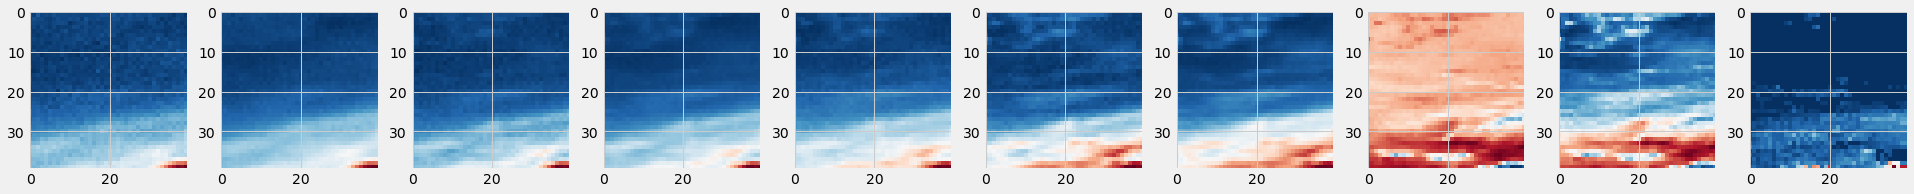

<Figure size 432x288 with 0 Axes>

In [35]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()
plt.tight_layout() # figure 크기에 맞게 layout 정렬

## 변수 선택 및 모델 구축 (Feature Engineering & Initial Modeling)
* 모델 구축
* [활용한 코드1](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) 
* [활용한 코드2](https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification)

In [36]:
def build_model(input_layer, start_neurons):
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

In [37]:
input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [38]:
model = Model(input_layer, output_layer)

* Loss fuction 정의
* [TensorFlow에 custom metrics 적용하는 코드](https://dacon.io/competitions/official/235584/codeshare/738)

In [39]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def mae_over_fscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def mae_over_fscore_keras(y_true, y_pred):
    score = tf.py_function(func=mae_over_fscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [40]:
model.compile(loss="mae", optimizer="adam", metrics=[mae_over_fscore_keras, fscore_keras])

## 모델 학습 및 검증 (Model Tuning & Evaluation)

In [41]:
model_history = model.fit(train_dataset, epochs=1, verbose=1)

6/6 [==============================] - 967s 155s/step - loss: 1.3716 - mae_over_fscore_keras: 4.8074 - fscore_keras: 0.5275


In [42]:
X_test.shape

(2416, 40, 40, 9)

In [43]:
pred = model.predict(X_test)

In [74]:
submission = pd.read_csv(os.path.join(root_path, 'submission/sample_submission.csv'))
submission.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,px_11,px_12,px_13,px_14,px_15,px_16,px_17,px_18,px_19,px_20,px_21,px_22,px_23,px_24,px_25,px_26,px_27,px_28,px_29,px_30,px_31,px_32,px_33,px_34,px_35,px_36,px_37,px_38,px_39,...,px_1561,px_1562,px_1563,px_1564,px_1565,px_1566,px_1567,px_1568,px_1569,px_1570,px_1571,px_1572,px_1573,px_1574,px_1575,px_1576,px_1577,px_1578,px_1579,px_1580,px_1581,px_1582,px_1583,px_1584,px_1585,px_1586,px_1587,px_1588,px_1589,px_1590,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,029858_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,029858_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,029858_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,029858_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
print(pred.shape)
print(submission.iloc[:,1:].shape)

(2416, 40, 40, 1)
(2416, 1600)


In [76]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [77]:
import datetime

# UTC 기준
time_log = datetime.datetime.now().strftime('%m%d_%H%M') # "strftime": string formatting time
time_log

'0824_0127'

In [78]:
import datetime

time_log = datetime.datetime.now()
kst_log = time_log + datetime.timedelta(hours=9)
kst_log = kst_log.strftime('%m%d_%H%M') # "strftime": string formatting time
kst_log

'0824_1027'

In [84]:
submission_file = f'./submission/baseline_{kst_log}.csv'
submission_file

'./submission/baseline_0824_1027.csv'

In [85]:
submission.to_csv(submission_file, index = False)

## Dacon API 활용하여 제출 
* [튜토리얼](https://dacon.io/forum/403588?dtype=recent)

In [72]:
!pip install ./submission/dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl


In [73]:
from dacon_submit_api import dacon_submit_api 


```
result = dacon_submit_api.post_submission_file(
'파일경로', 
'개인 Token', # 계정관리에서 각자 개인 토큰 활용해주세요!
'대회ID', # https://dacon.io/competitions/official/235591/overview/prize 대회 링크에 있는 6자리 번호
'팀이름', 
'submission 메모 내용' ) # 정확도나, 시도 사항들을 기록해두는 것이 좋습니다.
```


![image](https://user-images.githubusercontent.com/69677950/130543113-e711437a-161b-4891-8834-836d0e868cbe.png)


In [86]:
result = dacon_submit_api.post_submission_file(
    submission_file,  # 파일 경로
    '',  # 꼭 계정관리의 본인 토큰 활용해주세요!
    '235591',  # 대회 번호
    '',  # 팀 이름/계정 이름
    ''  # 메모 내용 e.g. 변경사항/시도사항
    )

{'isSubmitted': True, 'detail': 'Success'}


**API 활용한 제출 결과**
![image](https://user-images.githubusercontent.com/69677950/130542269-33a9b0fe-c88f-4c18-85e5-548549ba24d2.png)

## 결과 및 결언 (Conclusion & Discussion)